In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

2025-03-20 06:56:22.875599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742453782.886757    5815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742453782.889966    5815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742453782.900003    5815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453782.900016    5815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453782.900018    5815 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv("SPAM text message 20170820 - Data (1).csv")

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df.sample(15)

,Category,Message
3799,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
3658,ham,Studying. But i.ll be free next weekend.
387,ham,Customer place i will call you.
4481,ham,Y cant u try new invention to fly..i'm not jok...
513,ham,Lol ok your forgiven :)
840,spam,Last chance 2 claim ur £150 worth of discount ...
2768,ham,Wow v v impressed. Have funs shopping!
4814,ham,i can call in &lt;#&gt; min if thats ok
1997,ham,Lol boo I was hoping for a laugh
5323,ham,Aah bless! How's your arm?


In [8]:
df.shape

(5572, 2)

In [9]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [10]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [11]:
# Step 1: Data Preprocessing
# Encode labels (ham -> 0, spam -> 1)
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

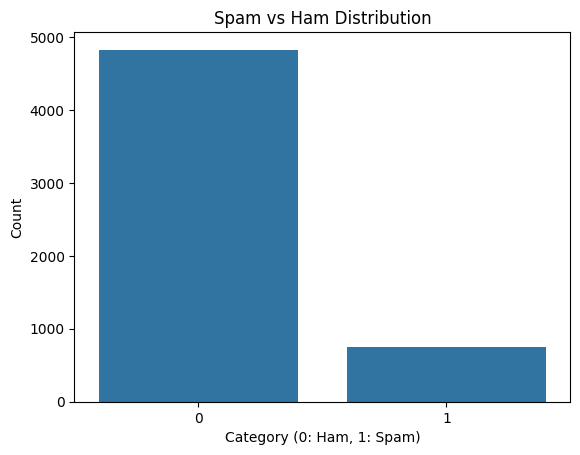

In [12]:
# Visualize class distribution
sns.countplot(x=df['Category'])
plt.title('Spam vs Ham Distribution')
plt.xlabel('Category (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.show()

In [13]:
# Tokenize and pad text data
tokenizer = Tokenizer(num_words=5000)  # Use top 5000 words
tokenizer.fit_on_texts(df['Message'])
X = tokenizer.texts_to_sequences(df['Message'])
X = pad_sequences(X, maxlen=100)  # Pad/truncate to 100 words
y = df['Category']

In [14]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Step 2: Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))  # Word embeddings
model.add(LSTM(64, return_sequences=False))  # LSTM layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

/home/zahir/Tf_gpu/tfgpu1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1742453785.407508    5815 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,421 (7.89 MB)

 Trainable params: 689,473 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,378,948 (5.26 MB)

In [17]:
# Step 3: Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.2)

Epoch 1/5


I0000 00:00:1742453786.863708    5885 cuda_dnn.cc:529] Loaded cuDNN version 90300


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8113 - loss: 0.5128 - val_accuracy: 0.8778 - val_loss: 0.2445
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9468 - loss: 0.1832 - val_accuracy: 0.9540 - val_loss: 0.1650
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9788 - loss: 0.0948 - val_accuracy: 0.9697 - val_loss: 0.1089
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9855 - loss: 0.0656 - val_accuracy: 0.9765 - val_loss: 0.0778
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9899 - loss: 0.0393 - val_accuracy: 0.9843 - val_loss: 0.0703


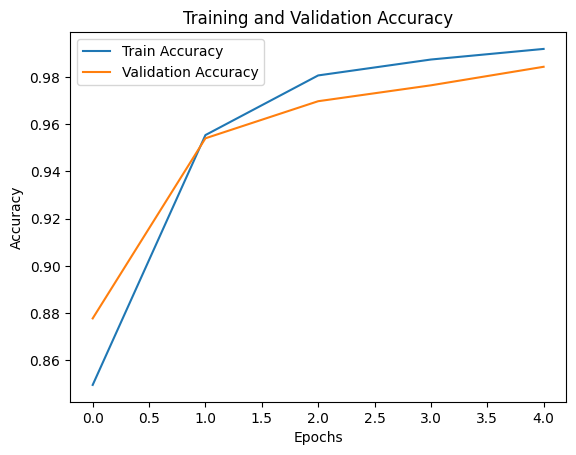

In [18]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

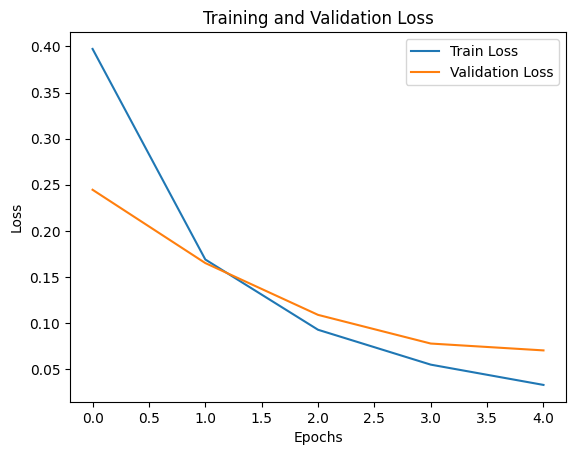

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Step 4: Evaluate the Model
# y_pred = (model.predict(X_test) > 0.5).astype(int)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
# Display accuracy in a better format
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.989237668161435
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.98      0.94      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



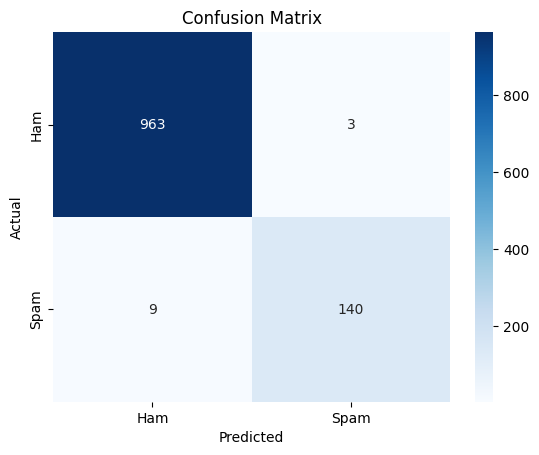

In [21]:
# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [22]:
# Step 5: Save the Model
model.save('spam_ham_lstm_model.h5')
print("Model saved successfully!")

Model saved successfully!
